## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [2]:
from main import *

ari = AnisoResInv()

In [3]:
well1 = lasio.read('well1.las').df()
#ari.plot_well_1(well1)

In [4]:
well2 = lasio.read('well2.LAS').df()
#ari.plot_well_2(well2)

In [8]:
well1['Csh_lin'] = (well1['GR'] - well1['GR'].min()) / (well1['GR'].max() - well1['GR'].min())
well2['Csh_lin'] = (well2['HCGR'] - well2['HCGR'].min()) / (well2['HCGR'].max() - well2['HCGR'].min())

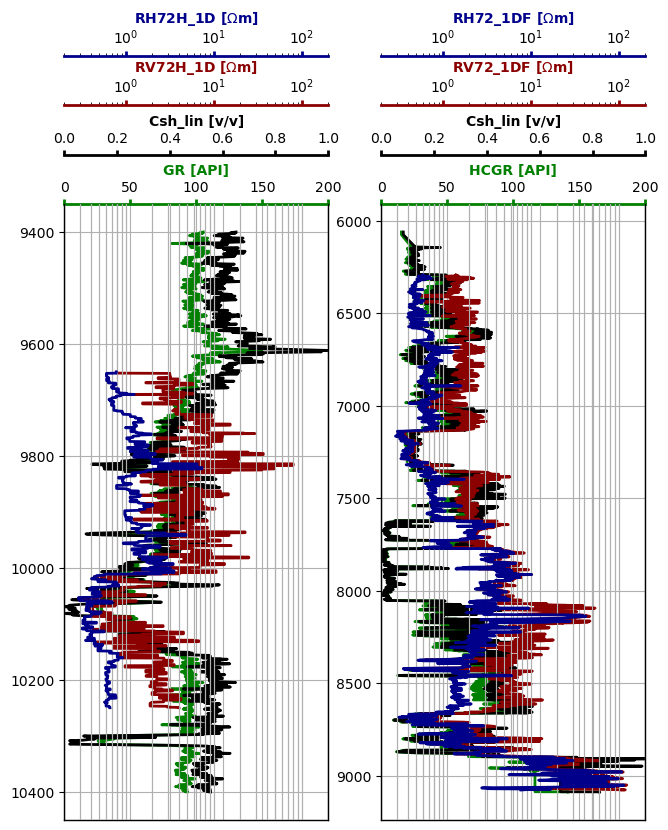

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(7.5,8))
ax1, ax2 = axs

ax11, ax12, ax13 = ax1.twiny(), ax1.twiny(), ax1.twiny()
ax21, ax22, ax23 = ax2.twiny(), ax2.twiny(), ax2.twiny()

ari.plot_curve(ax1, well1, 'GR', 0, 200, 'g', units='API')
ari.plot_curve(ax11, well1, 'Csh_lin', 0, 1, 'k', units='v/v', pad=8)
ari.plot_curve(ax12, well1, 'RV72H_1D', 0.2, 200, 'darkred', units='$\Omega$m', semilog=True, pad=16)
ari.plot_curve(ax13, well1, 'RH72H_1D', 0.2, 200, 'darkblue', units='$\Omega$m', semilog=True, pad=24)

ari.plot_curve(ax2, well2, 'HCGR', 0, 200, 'g', units='API')
ari.plot_curve(ax21, well2, 'Csh_lin', 0, 1, 'k', units='v/v', pad=8)
ari.plot_curve(ax22, well2, 'RV72_1DF', 0.2, 200, 'darkred', units='$\Omega$m', semilog=True, pad=16)
ari.plot_curve(ax23, well2, 'RH72_1DF', 0.2, 200, 'darkblue', units='$\Omega$m', semilog=True, pad=24)

ax1.invert_yaxis(); ax2.invert_yaxis()
plt.show()

***
# END